# Trashnet Dataset Preprocessing
This notebook downloads and preprocesses the garythung/trashnet dataset from HuggingFace.

Dataset: https://huggingface.co/datasets/garythung/trashnet


In [10]:
import sys, subprocess, pkgutil
print("Using Python:", sys.executable)

# install into THIS kernel's interpreter
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "datasets", "pillow"])

import torch
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


Using Python: d:\downloads_from_edge\engg123\venv\Scripts\python.exe
Torch: 2.6.0+cu124 | CUDA available: True


In [11]:
# Imports
from __future__ import annotations
import random
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# HuggingFace datasets is REQUIRED
try:
    from datasets import load_dataset
except Exception as e:
    raise RuntimeError(
        "datasets is required. Install with: pip install datasets\n"
        f"Import error: {e}"
    )

print("datasets library successfully imported.")


datasets library successfully imported.


In [12]:
# Reproducibility + device pick
# ------------------------------
def set_seed(seed: int = 56) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def pick_device() -> torch.device:
    if torch.cuda.is_available():
        d = torch.device("cuda")
        print(f"[Device] CUDA: {torch.cuda.get_device_name(0)}")
        return d
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("[Device] MPS (Apple Metal)")
        return torch.device("mps")
    print("[Device] CPU")
    return torch.device("cpu")

def get_num_workers(requested_workers: int = 2) -> int:
    """
    Get the appropriate number of DataLoader workers for the current platform.
    
    On Windows, multiprocessing with DataLoaders can cause worker crashes due to
    the spawn method used for process creation. Setting num_workers=0 forces
    single-process loading which is more stable on Windows.
    
    Args:
        requested_workers: Desired number of workers (used on non-Windows platforms)
    
    Returns:
        Number of workers to use (0 on Windows, requested_workers otherwise)
    """
    import platform
    if platform.system() == 'Windows':
        print(f"[Platform] Windows detected: Using num_workers=0 (single-process loading)")
        print(f"           This avoids multiprocessing issues on Windows.")
        return 0
    return requested_workers


In [13]:
# Transforms
# ------------------------------
def build_transforms(img_size: int) -> Tuple[transforms.Compose, transforms.Compose]:
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.03),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return train_tf, eval_tf


In [14]:
# Custom PyTorch Dataset for HuggingFace datasets
# ------------------------------
class HuggingFaceImageDataset(Dataset):
    """Wraps a HuggingFace dataset with PyTorch transforms."""
    
    def __init__(self, hf_dataset, transform=None, label_key="label", image_key="image"):
        """
        Args:
            hf_dataset: HuggingFace dataset split (e.g., ds['train'])
            transform: torchvision transforms to apply
            label_key: name of the label column in the dataset
            image_key: name of the image column in the dataset
        """
        self.dataset = hf_dataset
        self.transform = transform
        self.label_key = label_key
        self.image_key = image_key
        
        # Extract class names if available
        if hasattr(hf_dataset.features[label_key], 'names'):
            self.classes = hf_dataset.features[label_key].names
        else:
            self.classes = []
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item[self.image_key]
        label = item[self.label_key]
        
        # Convert to PIL Image if not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        
        # Ensure RGB mode
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [18]:
# HuggingFace dataset loader
# ------------------------------
def load_trashnet_dataset(
    dataset_name: str = "garythung/trashnet",
    img_size: int = 224,
    batch_size: int = 64,
    num_workers: int = 2,
    val_ratio: float = 0.2,
    test_ratio: float = 0.0,
    seed: int = 56,
) -> Tuple[DataLoader, DataLoader, Optional[DataLoader], Dict]:
    """
    Loads the trashnet dataset from HuggingFace and creates PyTorch DataLoaders.
    
    Args:
        dataset_name: HuggingFace dataset identifier
        img_size: Target image size for resizing
        batch_size: Batch size for DataLoaders
        num_workers: Number of workers for DataLoaders
        val_ratio: Validation split ratio (default: 0.2 = 20%)
        test_ratio: Test split ratio (default: 0.0 = 0%, no test set)
        seed: Random seed for reproducible splits
    
    Returns:
        train_loader, val_loader, test_loader, metadata dict
    """
    print(f"[HuggingFace] Loading dataset '{dataset_name}' ...")
    
    # Load the dataset
    ds = load_dataset(dataset_name)
    
    print(f"[HuggingFace] Dataset loaded. Available splits: {list(ds.keys())}")
    print(f"[HuggingFace] Dataset info: {ds}")
    
    # Build transforms
    train_tf, eval_tf = build_transforms(img_size)
    
    # Check what splits are available
    has_train = 'train' in ds
    has_val = 'validation' in ds or 'val' in ds
    has_test = 'test' in ds
    
    # Initialize test_dataset
    test_dataset = None
    
    # Create datasets
    if has_train:
        original_train = ds['train']
        classes = original_train.features['label'].names if hasattr(original_train.features['label'], 'names') else []
        print(f"[Dataset] Original train samples: {len(original_train)}")
    else:
        raise ValueError("No 'train' split found in the dataset")
    
    if has_val:
        val_key = 'validation' if 'validation' in ds else 'val'
        val_dataset = HuggingFaceImageDataset(ds[val_key], transform=eval_tf)
        train_dataset = HuggingFaceImageDataset(ds['train'], transform=train_tf)
        print(f"[Dataset] Using pre-existing validation split: {len(val_dataset)} samples")
    elif has_test and val_ratio == 0:
        # Use test as validation if no validation split and val_ratio is 0
        val_dataset = HuggingFaceImageDataset(ds['test'], transform=eval_tf)
        train_dataset = HuggingFaceImageDataset(ds['train'], transform=train_tf)
        test_dataset = None
        print(f"[Dataset] Using test split as validation: {len(val_dataset)} samples")
    else:
        # Create validation (and optionally test) split from training data
        print(f"[Dataset] No validation/test splits found. Creating splits...")
        print(f"[Dataset] Split ratios - Train: {(1-val_ratio-test_ratio)*100:.1f}% | Val: {val_ratio*100:.1f}% | Test: {test_ratio*100:.1f}%")
        
        if test_ratio > 0:
            # First split: separate test set
            train_val_test_split = original_train.train_test_split(test_size=test_ratio, seed=seed)
            test_ds_raw = train_val_test_split['test']
            train_val_ds_raw = train_val_test_split['train']
            
            # Second split: separate train and validation from remaining data
            # Adjust val_ratio to account for already removed test data
            adjusted_val_ratio = val_ratio / (1 - test_ratio)
            train_val_split = train_val_ds_raw.train_test_split(test_size=adjusted_val_ratio, seed=seed)
            
            train_dataset = HuggingFaceImageDataset(train_val_split['train'], transform=train_tf)
            val_dataset = HuggingFaceImageDataset(train_val_split['test'], transform=eval_tf)
            test_dataset = HuggingFaceImageDataset(test_ds_raw, transform=eval_tf)
            
            print(f"[Dataset] Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
        else:
            # Just split into train and validation
            train_val_split = original_train.train_test_split(test_size=val_ratio, seed=seed)
            train_dataset = HuggingFaceImageDataset(train_val_split['train'], transform=train_tf)
            val_dataset = HuggingFaceImageDataset(train_val_split['test'], transform=eval_tf)
            print(f"[Dataset] Train: {len(train_dataset)} | Val: {len(val_dataset)}")
    
    # Handle original test split if it exists and we haven't created our own
    if has_test and test_dataset is None:
        test_dataset = HuggingFaceImageDataset(ds['test'], transform=eval_tf)
        print(f"[Dataset] Using original test split: {len(test_dataset)} samples")
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = None
    if test_dataset:
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
    
    # Metadata
    meta = {
        "classes": classes,
        "num_classes": len(classes),
        "img_size": img_size,
        "dataset_name": dataset_name,
    }
    
    return train_loader, val_loader, test_loader, meta


In [19]:
# Summary helper
# ------------------------------
def summarize_loaders(train_ld, val_ld, test_ld, meta, device):
    """Print a comprehensive summary of the data loaders."""
    
    def ds_len(loader):
        if loader is None:
            return 0
        return len(loader.dataset)
    
    print("\n" + "="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Dataset: {meta.get('dataset_name', 'Unknown')}")
    print(f"Device: {device.type.upper()}")
    
    classes = meta.get("classes", [])
    print(f"\nNumber of classes: {len(classes)}")
    
    if len(classes) <= 10:
        print(f"Classes: {classes}")
    else:
        preview = classes[:10]
        print(f"Classes (first 10): {preview}")
        print(f"         ... and {len(classes) - 10} more")
    
    print(f"\nDataset sizes:")
    print(f"  Train:      {ds_len(train_ld):5d} samples")
    print(f"  Validation: {ds_len(val_ld):5d} samples")
    print(f"  Test:       {ds_len(test_ld):5d} samples")
    
    total = ds_len(train_ld) + ds_len(val_ld) + ds_len(test_ld)
    print(f"  Total:      {total:5d} samples")
    
    try:
        # Peek one batch from training loader
        xb, yb = next(iter(train_ld))
        print(f"\nSample batch shape:")
        print(f"  Images: {tuple(xb.shape)}  (B, C, H, W)")
        print(f"  Labels: {tuple(yb.shape)}")
        print(f"  Image dtype: {xb.dtype}")
        print(f"  Image range: [{xb.min():.3f}, {xb.max():.3f}]")
    except Exception as e:
        print(f"\n[Warning] Could not fetch a sample batch: {e}")
    
    print("="*60 + "\n")


In [20]:
# ---- RUN PIPELINE IN NOTEBOOK ----

# Settings you can tweak
DATASET_NAME = "garythung/trashnet"
IMG_SIZE     = 224
BATCH_SIZE   = 64
NUM_WORKERS  = 2    # Will be auto-adjusted to 0 on Windows
VAL_RATIO    = 0.2  # 20% for validation
TEST_RATIO   = 0.05 # 5% for test (set to 0.0 for no test set)
SEED         = 56

# 1) Set seed + pick device
set_seed(SEED)
device = pick_device()

# 2) Adjust num_workers for platform compatibility
num_workers_adjusted = get_num_workers(NUM_WORKERS)

# 3) Load dataset and create DataLoaders
train_ld, val_ld, test_ld, meta = load_trashnet_dataset(
    dataset_name=DATASET_NAME,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=num_workers_adjusted,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED,
)

# 4) Print summary
summarize_loaders(train_ld, val_ld, test_ld, meta, device)


[Device] CUDA: NVIDIA GeForce RTX 4070 Laptop GPU
[Platform] Windows detected: Using num_workers=0 (single-process loading)
           This avoids multiprocessing issues on Windows.
[HuggingFace] Loading dataset 'garythung/trashnet' ...
[HuggingFace] Dataset loaded. Available splits: ['train']
[HuggingFace] Dataset info: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})
[Dataset] Original train samples: 5054
[Dataset] No validation/test splits found. Creating splits...
[Dataset] Split ratios - Train: 75.0% | Val: 20.0% | Test: 5.0%
[Dataset] Train: 3790 | Val: 1011 | Test: 253

DATA SUMMARY
Dataset: garythung/trashnet
Device: CUDA

Number of classes: 6
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Dataset sizes:
  Train:       3790 samples
  Validation:  1011 samples
  Test:         253 samples
  Total:       5054 samples

Sample batch shape:
  Images: (64, 3, 224, 224)  (B, C, H, W)
  Labels: (64,)
  Imag

In [21]:
# Optional: Save dataset to disk in a folder structure
# ------------------------------
def save_dataset_to_disk(
    hf_dataset,
    output_dir: Path,
    split_name: str = "train",
    label_key: str = "label",
    image_key: str = "image",
):
    """
    Saves a HuggingFace dataset to disk in ImageFolder format.
    
    Args:
        hf_dataset: HuggingFace dataset split
        output_dir: Root directory to save images
        split_name: Name of the split (train/val/test)
        label_key: Column name for labels
        image_key: Column name for images
    """
    output_path = Path(output_dir) / split_name
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Get class names
    if hasattr(hf_dataset.features[label_key], 'names'):
        class_names = hf_dataset.features[label_key].names
    else:
        class_names = [f"class_{i}" for i in range(max(hf_dataset[label_key]) + 1)]
    
    # Create class directories
    for class_name in class_names:
        (output_path / class_name).mkdir(exist_ok=True)
    
    print(f"Saving {split_name} split to {output_path}...")
    
    # Save images
    for idx in range(len(hf_dataset)):
        item = hf_dataset[idx]
        image = item[image_key]
        label = item[label_key]
        class_name = class_names[label]
        
        # Convert to PIL if needed
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        
        # Ensure RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Save image
        image_path = output_path / class_name / f"{split_name}_{idx:05d}.jpg"
        image.save(image_path, quality=95)
        
        if (idx + 1) % 100 == 0:
            print(f"  Saved {idx + 1}/{len(hf_dataset)} images...")
    
    print(f"✓ Saved {len(hf_dataset)} images to {output_path}")

# Uncomment to save the dataset to disk
# OUTPUT_DIR = Path("data_split")
# from datasets import load_dataset
# ds = load_dataset(DATASET_NAME)
# for split in ds.keys():
#     save_dataset_to_disk(ds[split], OUTPUT_DIR, split_name=split)


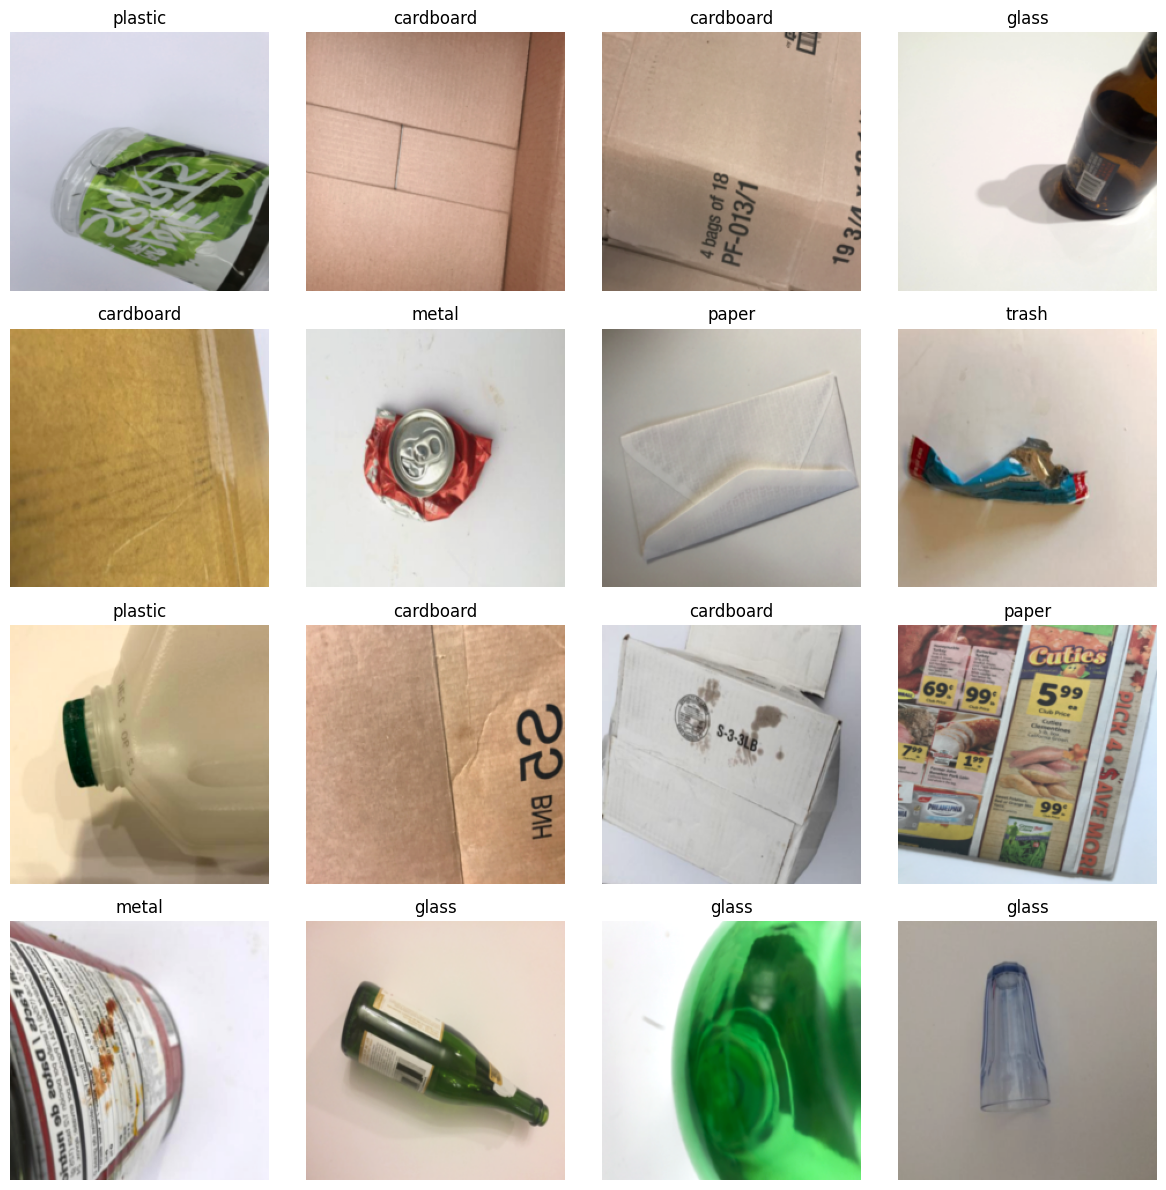

In [ ]:
# Optional: Visualize some samples
# ------------------------------
import matplotlib.pyplot as plt

def visualize_samples(loader, meta, num_samples=16):
    """
    Visualize a grid of sample images from the loader.
    
    Args:
        loader: DataLoader to sample from
        meta: Metadata dictionary with class names
        num_samples: Number of samples to display
    """
    classes = meta.get('classes', [])
    
    # Get a batch
    images, labels = next(iter(loader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    # Create grid
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, (img, label) in enumerate(zip(images, labels)):
        if idx >= len(axes):
            break
        
        # Convert to numpy and transpose
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[idx].imshow(img_np)
        axes[idx].axis('off')
        if classes:
            axes[idx].set_title(f"{classes[label.item()]}")
        else:
            axes[idx].set_title(f"Label: {label.item()}")
    
    # Hide unused subplots
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize samples
# visualize_samples(train_ld, meta, num_samples=16)
